<center><font size='5'>Card shuffling</font></center>
<center><font size='3'>Eric Martin, CSE, UNSW</font></center>
<center><font size='3'>COMP9021 Principles of Programming</font></center>

In [4]:
# Does not need to be executed if
# ~/.ipython/profile_default/ipython_config.py
# exists and contains:
# c.InteractiveShell.ast_node_interactivity = 'all'

from IPython.core.interactiveshell import InteworactiveShell
InteractiveShell.ast_node_interactivity = 'all'

ImportError: cannot import name 'InteworactiveShell' from 'IPython.core.interactiveshell' (/Users/kevinngx/.pyenv/versions/3.11.0/lib/python3.11/site-packages/IPython/core/interactiveshell.py)

In [5]:
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

In [6]:
from random import randrange
import matplotlib.pyplot as plt
from sys import getsizeof

The program [card_shuffling.py](card_shuffling.py) creates a widget to simulate the shuffling of a 56-card deck which to start with, is supposed to be brand new, with from top to bottom, the cards facing up, all Spades from Ace up to King, then all Diamonds from Ace up to King, then all Clubs from King down to Ace, and finally all Hearts from King down to Ace (a 56-card deck has Knights between Jacks and Queens). The Unicode character set has pictures of these cards, but in the order from Ace up to King for all colours, and with gaps between colours:

* from code point 0x1F0A1 to code point 0x1F0AE, all Spades;
* from code point 0x1F0B1 to code point 0x1F0BE, all Hearts;
* from code point 0x1F0C1 to code point 0x1F0CE, all Diamonds;
* from code point 0x1F0D1 to code point 0x1F0DE, all Clubs.

Let us keep track of

* the colours in the order in which they appear in the Unicode character set,
* the code point of the first Ace, the Ace of Spades, and
* the offsets to add to the code point of an Ace of a given colour to get all cards of that colour, from Ace up to King:

In [7]:
colours = 'spades', 'hearts', 'diamonds', 'clubs'
first_ace_code_point = 0x1F0A1
suit = range(14)

For Hearts and Clubs, the order of offsets needs to be reversed to yield cards of those colours in the order they have in a brand new deck; we define a function to, for a given colour, get the right order:

In [8]:
def default_suit_order(colour):
    return suit if colour in {'spades', 'diamonds'} else reversed(suit)

We can now define a deck as a list `deck` that stores the characters that represent all cards in the same order as in a brand new deck of cards. We use a list comprehension with two `for` statements. The syntax of (list and other forms of) comprehension allows for an arbitrary number of `for` statements, that can be associated with `if` statements, respecting the order they would have in the corresponding "classical" syntax. For instance, both code fragments build the same list:

In [9]:
L = []
for i in 'abcd':
    if i in 'ac':
        for j in '123':
            for k in 'ABCD':
                if k in 'BD':
                    L.append((i, j, k))
L

[('a', '1', 'B'),
 ('a', '1', 'D'),
 ('a', '2', 'B'),
 ('a', '2', 'D'),
 ('a', '3', 'B'),
 ('a', '3', 'D'),
 ('c', '1', 'B'),
 ('c', '1', 'D'),
 ('c', '2', 'B'),
 ('c', '2', 'D'),
 ('c', '3', 'B'),
 ('c', '3', 'D')]

In [10]:
L = [(i, j, k) for i in 'abcd' if i in 'ac'
                   for j in '123'
                       for k in 'ABCD' if k in 'BD'
    ]
L

[('a', '1', 'B'),
 ('a', '1', 'D'),
 ('a', '2', 'B'),
 ('a', '2', 'D'),
 ('a', '3', 'B'),
 ('a', '3', 'D'),
 ('c', '1', 'B'),
 ('c', '1', 'D'),
 ('c', '2', 'B'),
 ('c', '2', 'D'),
 ('c', '3', 'B'),
 ('c', '3', 'D')]

In a brand new deck of cards, colours appear in the order `colours[0]`, `colours[2]`, `colours[3]` and `colours[1]`. Also, the difference between the code points of two consecutive Aces is 16. Hence we can define `deck` as follows:

In [11]:
deck = [chr(first_ace_code_point + i * 16 + j) for i in (0, 2, 3, 1)
            for j in default_suit_order(colours[i])
       ]

Let us define a simple function to display the deck over 4 lines, so with one line for each colour when `deck` represents a brand new deck of cards that has not been shuffled yet:

In [23]:
def display_deck():
    print('\n'.join(' '.join(deck[i * 14 + j] for j in suit)
                                 for i in range(4)
                   )
         )

display_deck()

🃅 🃗 🂧 🃉 🃇 🂶 🂺 🃆 🂬 🂱 🃘 🃝 🂩 🃔
🂪 🃛 🃜 🃞 🂥 🃄 🂹 🃈 🃍 🃕 🂮 🃚 🂸 🃓
🂵 🃒 🂢 🂡 🃎 🂤 🂻 🃁 🃖 🂷 🃃 🂴 🃂 🂫
🂼 🂳 🂽 🂲 🂦 🃋 🃑 🂨 🂾 🂣 🃙 🃊 🃌 🂭


The first step in shuffling the deck is to cut it and get two stacks, stack 1 and stack 2. Intuitively, there is a high chance that the cut divides the deck in two equal stacks, and a smaller chance that one stack is larger than the other; the chance is all the more smaller that the difference between the sizes of both stacks increases. Both stacks play a symmetric role. We let the cards face down, so the card of index 0 is at the bottom of the deck and the card of index 55 at the top of the deck. Cutting the deck is well formalised thanks to a binomial distribution. On can imagine 56 flips of a fair coin, that if it starts with Heads, Heads, Tail, Heads, Tail, Tail... can be interpreted as:

* Card of index 0 bottommost card of stack 1
* Card of index 1 second bottommost card of stack 1
* Card of index 55 topmost card of stack 2
* Card of index 2 third bottommost card of stack 1
* Card of index 54 second topmost card of stack 2
* Card of index 53 third topmost card of stack 2
* ...

The number of Heads determines the size of stack 1. It can also be interpreted as the index of the card at the bottom of stack 2:

* equal to 0 in one of the two most unlikely cases, where stack 1 is empty and stack 2 is the whole deck,
* equal to 56 in the other most unlikely case, where stack 1 is the whole deck and stack 2 is empty,
* equal to 28 in the most likely case, where both stacks have the same size.

The code that follows implements the generation of a value for the variable `cut` in accordance with that random process:

In [13]:
nb_of_cards = 56
# 57 possible outcomes
cut = sum(randrange(2) for _ in range(nb_of_cards))
cut

28

After the deck has been cut in two stacks, the cards of both stacks should be entwined to finish shuffling. The process is again probabilistic. If both stacks have the same number of cards, then there is an equal chance that either the card at the bottom of stack 1 or the card at the bottom of stack 2 becomes the card at the bottom of the shuffled deck. The larger one stack is compared to the other stack, the higher the chance that the bottom card in the shuffled deck comes from the former. If there are $p$ cards in stack 1 and $q$ cards in stack 2, a good formalisation gives a $\frac{p}{p+q}$ probability for the bottom card in the shuffled deck to come from the bottom of stack 1. To start with, $p$ is equal to `cut` and $q$ is equal to `nb_of_cards - cut`. The same reasoning applies to determine which card becomes the second bottommost card in the shuffled deck, which decreases either $p$ or $q$ by 1, and which card becomes the third bottommost card in the shuffled deck, which decreases either $p$ or $q$ by 1... until one of both stacks becomes empty -- stack 1 if $p$ becomes equal to 0 first, stack 2 if $q$ becomes equal to 0 first. What remains of the other stack gets to the top of the shuffled deck.

To select the card at the bottom of stack 1 with a probability of $\frac{p}{p+q}$, it suffices to randomly generate a natural number smaller than $p+q$, and test whether it is smaller than $p$:

In [14]:
# 10,000 times, there are 2/5 chances for the test to be true,
# so we expect the second number to be a reasonable approximation
# of the first one.
2/5, sum(randrange(5) < 2 for _ in range(10_000)) / 10_000
# 10,000 times, there are 3/8 chances for the test to be true,
# so we expect the second number to be a reasonable approximation
# of the first one.
3/8, sum(randrange(8) < 3 for _ in range(10_000)) / 10_000

(0.375, 0.3697)

Let us define a number of variables:

* `combined_size_of_stacks`, initialised to `nb_of_cards`, to keep track of how many cards are left in both stacks;
* `i_1`, initialised to `0`, to keep track of the position in stack 1 of the first card that is not part of the shuffled deck yet.
* `i_2`, initialised to `cut`, to keep track of the position in stack 2 of the first card that is not part of the shuffled deck yet.

At any stage, either `i_1` gets increased by 1 because the card at the bottom of what remains of stack 1 becomes part of the shuffled deck, or `i_2` gets increased by 1 because it is instead the card at the bottom of what remains of stack 2 that becomes part of the shuffled deck. Since `cut - i_1` evaluates to the current size of stack 1, and `nb_of_cards - i_2` to the current size of stack 2, we could do without `combined_size_of_stacks` and work instead with `cut - i_1 + nb_of_cards - i_2`.

Let us first implement this method to the point where one of the stacks becomes empty and trace execution of the code, but with a small deck of only 7 cards, abstracted as the natural numbers 0, 1, 2, 3, 4, 5, 6 rather than being characters that depict cards, and fixing the value of `cut` to `4`; so stack 1 consists of cards 0, 1, 2 and 3, while stack 2 consists of cards 4, 5 and 6. When execution terminates, either stack 1 is empty, in which case card 3 (facing down) is at the top of the shuffled deck, or stack 2 is empty, in which case card 6 (facing down) is at the top of the shuffled deck. 

In [24]:
nb_of_cards = 7
deck = list(range(nb_of_cards))
cut = 4
shuffled_deck = []
i_1 = 0
i_2 = cut
combined_size_of_stacks = nb_of_cards

while i_1 < cut and i_2 < nb_of_cards:
    if randrange(combined_size_of_stacks) < cut - i_1:
        shuffled_deck.append(deck[i_1])
        i_1 += 1
        print('Card coming from stack 1, shuffled deck becomes', shuffled_deck)
    else:
        shuffled_deck.append(deck[i_2])
        i_2 += 1
        print('Card coming from stack 2, shuffled deck becomes', shuffled_deck)
    combined_size_of_stacks -= 1

Card coming from stack 1, shuffled deck becomes [0]
Card coming from stack 2, shuffled deck becomes [0, 4]
Card coming from stack 2, shuffled deck becomes [0, 4, 5]
Card coming from stack 1, shuffled deck becomes [0, 4, 5, 1]
Card coming from stack 2, shuffled deck becomes [0, 4, 5, 1, 6]


To bring to the top of the shuffled deck the rest of the nonempty stack, we can use the `extend()` method of the `list` class and use `slice` notation. Whereas `append()` adds only one element to a list, `extend()` concatenates a sequence to the end of a list:

In [16]:
L = [10, 11, 12]
L.extend([]); L
L.extend([0]); L
L.extend([1, 2]); L
L.extend((2, 3, 4)); L
L.extend(range(5, 10)); L

[10, 11, 12, 0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9]

Let us examine slice notation in detail. To get a copy of a selection of consecutive elements in a list, or a tuple, $L$, one optionally provides

* the index of the first element to include, and
* the index beyond that of the last element $e$ to include, which is therefore "invalid" in case $e$ is $L$'s last element:

In [17]:
L = [10, 11, 12, 13, 14, 15, 16, 17, 18]

# Alternatively: L[0 : x] x with x >= len(L)
L[:]
# Alternatively: L[2 : x] x with x >= len(L)
L[2 :]
# Alternatively: L[-2 : x] x with x >= len(L)
L[-2 :]
# Alternatively: L[x : 4] with x == 0 or x < -len(L)
L[: 4]
# Alternatively: L[x : -4] with x == 0 or x < -len(L)
L[: -4]
L[60 : -30]
L[3 : 6]
L[-7 : -1]

[12, 13, 14, 15, 16, 17]

With a second colon, we can optionally provide a step to jump over a given number of elements:

In [18]:
# The step is 1 by default
L[::]
# Equivalent to [-1 : -1 - len(L) : -1]
L[:: -1]
L[:: 2]
L[:: 3]
L[: 7 : 2]
L[1 :: 3]
L[: 2 : -2]
L[-2 :: -3]

[17, 14, 11]

Slices can actually be defined on their own and then be "applied" to a list or a tuple: 

In [19]:
s = slice(8); s.start, s.stop, s.step
L[s]
s = slice(2, 8); s.start, s.stop, s.step
L[s]
s = slice(2, 8, 2); s.start, s.stop, s.step
L[s]

[12, 14, 16]

Getting back to our card simulation, let us complete the shuffling of the small deck of numbers betweeen 0 and 7 initially cut at position 4:

In [20]:
print('The shuffled deck is now', shuffled_deck)
if i_1 < cut:
    shuffled_deck.extend(deck[i_1 : cut])
else:
    shuffled_deck.extend(deck[i_2 :])
print('Finally, the shuffled deck is', shuffled_deck)

The shuffled deck is now [4, 5, 6]
Finally, the shuffled deck is [4, 5, 6, 0, 1, 2, 3]


Eventually assigning `shuffled_deck` to `deck` in effect shuffles the deck, and allows one to shuffle it once again, and once again (every time with a possibly different cut). Theory establishes that after 7 shuffles, the ordering of the cards in the deck has become random, in a precise sense. Back to our list of 56 card representations:

In [21]:
nb_of_cards = 56
deck = [chr(first_ace_code_point + i * 16 + j) for i in (1, 3, 2, 0)
            for j in default_suit_order(colours[i])
       ]
nb_of_shuffles = 7
print('Deck before shuffling:')
display_deck()
for k in range(nb_of_shuffles):
    shuffled_deck = []
    cut = sum(randrange(2) for _ in range(nb_of_cards))
    i_1 = 0
    i_2 = cut
    combined_size_of_stacks = nb_of_cards
    while i_1 < cut and i_2 < nb_of_cards:
        if randrange(combined_size_of_stacks) < cut - i_1:
            shuffled_deck.append(deck[i_1])
            i_1 += 1
        else:
            shuffled_deck.append(deck[i_2])
            i_2 += 1
        combined_size_of_stacks -= 1
    if i_1 < cut:
        shuffled_deck.extend(deck[i_1 : cut])
    else:
        shuffled_deck.extend(deck[i_2 :])
    deck = shuffled_deck
    print(f'Shuffle {k + 1}, deck is now:')
    display_deck()

Deck before shuffling:
🂾 🂽 🂼 🂻 🂺 🂹 🂸 🂷 🂶 🂵 🂴 🂳 🂲 🂱
🃞 🃝 🃜 🃛 🃚 🃙 🃘 🃗 🃖 🃕 🃔 🃓 🃒 🃑
🃁 🃂 🃃 🃄 🃅 🃆 🃇 🃈 🃉 🃊 🃋 🃌 🃍 🃎
🂡 🂢 🂣 🂤 🂥 🂦 🂧 🂨 🂩 🂪 🂫 🂬 🂭 🂮
Shuffle 1, deck is now:
🃃 🂾 🂽 🃄 🃅 🃆 🂼 🃇 🂻 🃈 🂺 🂹 🂸 🃉
🂷 🃊 🂶 🂵 🂴 🂳 🃋 🃌 🂲 🂱 🃞 🃍 🃎 🂡
🂢 🂣 🃝 🂤 🃜 🂥 🃛 🃚 🂦 🃙 🂧 🂨 🃘 🃗
🃖 🂩 🃕 🂪 🂫 🃔 🃓 🃒 🂬 🃑 🂭 🃁 🂮 🃂
Shuffle 2, deck is now:
🃃 🂾 🂢 🂽 🃄 🃅 🂣 🃆 🃝 🂤 🂼 🃇 🃜 🂻
🂥 🃛 🃈 🃚 🂦 🃙 🂺 🂧 🂨 🂹 🃘 🂸 🃉 🃗
🃖 🂩 🃕 🂷 🃊 🂶 🂪 🂵 🂴 🂫 🃔 🃓 🃒 🂳
🃋 🂬 🃑 🃌 🂲 🂱 🃞 🃍 🂭 🃎 🃁 🂡 🂮 🃂
Shuffle 3, deck is now:
🃉 🃃 🂾 🃗 🂢 🃖 🂽 🂩 🃕 🂷 🃊 🂶 🂪 🃄
🂵 🂴 🂫 🃅 🃔 🃓 🃒 🂣 🂳 🃋 🃆 🂬 🃝 🂤
🂼 🃑 🃌 🃇 🃜 🂻 🂲 🂱 🃞 🂥 🃛 🃈 🃍 🃚
🂦 🃙 🂭 🂺 🃎 🃁 🂧 🂡 🂨 🂮 🃂 🂹 🃘 🂸
Shuffle 4, deck is now:
🃉 🂱 🃞 🂥 🃃 🂾 🃗 🃛 🃈 🃍 🃚 🂢 🃖 🂽
🂦 🃙 🂭 🂺 🂩 🃕 🃎 🃁 🂷 🃊 🂧 🂶 🂪 🃄
🂵 🂴 🂫 🃅 🃔 🃓 🃒 🂡 🂨 🂣 🂮 🃂 🂳 🃋
🃆 🂬 🃝 🂹 🂤 🂼 🃑 🃌 🃇 🃘 🃜 🂸 🂻 🂲
Shuffle 5, deck is now:
🃅 🃉 🂱 🃔 🃞 🂥 🃓 🃒 🂡 🃃 🂨 🂾 🂣 🃗
🃛 🃈 🃍 🂮 🃚 🂢 🃖 🃂 🂳 🂽 🂦 🃋 🃙 🂭
🂺 🃆 🂬 🃝 🂩 🂹 🃕 🃎 🂤 🃁 🂷 🂼 🃑 🃊
🃌 🂧 🃇 🂶 🃘 🂪 🃜 🃄 🂸 🂵 🂻 🂴 🂫 🂲
Shuffle 6, deck is now:
🃅 🃉 🂺 🃆 🂬 🂱 🃝 🂩 🃔 🃞 🂥 🂹 🃕 🃓
🃒 🂡 🃎 🂤 🃁 🂷 🃃 🂼 🃑 🂨 🂾 🂣 🃊 🃌
🃗 🂧 🃇 🂶 🃘 🂪 🃛 🃜 🃄 🃈 🃍 🂮 🃚 🂸
🂵 🂢 🂻 🃖 🂴 🃂 🂫 🂳 🂽 🂲 🂦 🃋 🃙 🂭
Shuffle 7, deck is now:
🃅 🃗 🂧 🃉 🃇 🂶 🂺 🃆 🂬 🂱 🃘 🃝 🂩

`shuffled_deck` starts as an empty list, which a new element is appended up to 56 times (less in case the nonempty stack that remains contains more than one card). An alternative would have been to initialise `shuffled_deck` to `[None] * nb_of_cards`, introduce a new variable `j` initialised to `0`, and change the statements `shuffled_deck.append(deck[i])` with `i_1` or `i_2` for `i` to the two statements `shuffled_deck[j] = deck[i]; j += 1`. Creating an empty list and appending an element to this list $n$ times is not obviously more efficient than creating a list of size $n$ with a default value and changing each of its $n$ elements to the desired value. Indeed, the size of a list $L$ is not the same as its length: a list can possibly accomodate more elements than it currently "officially" has. When $L$ is full, `append()` does not necessarily just provide space for one extra element, but possibly space for many elements, and all the more space that the list is longer. So when appending elements again and again, times when the list is full and needs to be expanded to accomodate more elements come less and less frequently, in such a way that the __amortised cost__ of `append()` is constant: when the list is full and needs to be expanded and possibly copied over, the cost can be high, but the average cost over a large number of `append()` operations is constant. We can know the size of a list thanks to the function `getsizeof()` from the `sys` module. The following plot illustrates how the size of a list $L$ remains constant and suddenly jumps as elements are appended to $L$ one by one:

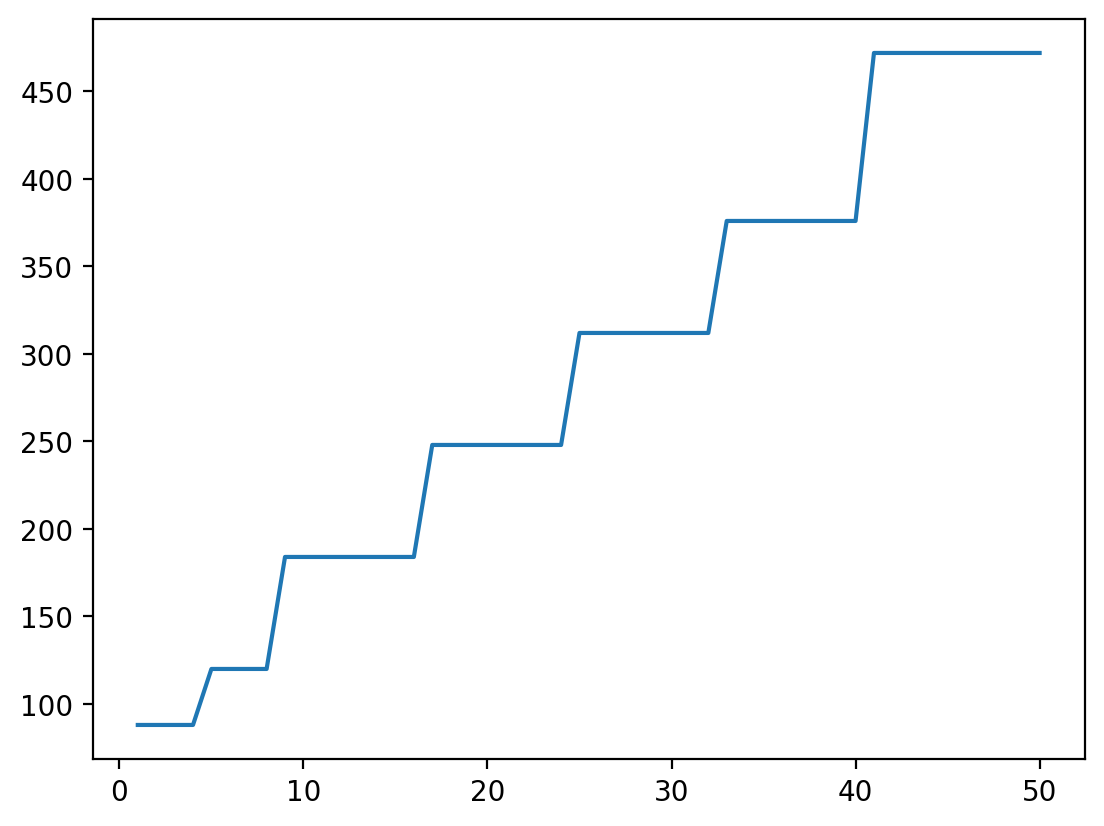

In [22]:
data = []
L = []
for i in range(1, 51):
    L.append(None)
    data.append((i, getsizeof(L)))
plt.plot(*zip(*data));

Contrast the previous plot with the following, when we create a list of a given length; then we get exactly the size we are asking for, possibly plus some fixed extra space:

In [ ]:
data = []
for i in range(1, 51):
    data.append((i, getsizeof([None] * i)))
plt.plot(*zip(*data));